# Compare GCHP and GCC NetCDF Diagnostics

## Overview of this Notebook

* Import dependencies
* Define general utility functions
* Define functions for regridding
* Define functions for plotting
* Define data directories
* Make regridding weights
* Store areas for normalization
* Compare restart files
* Compare diagnostic collections

## Import dependencies

In [1]:
import os
import numpy as np
import xarray as xr
import cubedsphere as cs
import xesmf as xe
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from cartopy import crs
from cartopy.mpl.geoaxes import GeoAxes

%matplotlib inline
import warnings; warnings.filterwarnings("ignore")

# Also define colormap. Colormap file source: https://bitbucket.org/gcst/gcpy
rgb_WhGrYlRd = np.genfromtxt('/n/home08/elundgren/GC/python/WhGrYlRd.txt',delimiter=' ')
WhGrYlRd = ListedColormap(rgb_WhGrYlRd/255.0)

## Define general utility functions

In [153]:
def get_gcc_filepath(outputdir, collection, day, time):
    if collection == 'Emissions':
        filepath = os.path.join(outputdir, 'HEMCO_diagnostics.{}{}.nc'.format(day,time))
    else:
        filepath = os.path.join(outputdir, 'GEOSChem.{}.{}_{}z.nc4'.format(collection,day,time))
    return filepath

In [154]:
def get_gchp_filepath(outputdir, collection, day, time):
    filepath = os.path.join(outputdir, 'GCHP.{}.{}_{}z.nc4'.format(collection,day,time))
    return filepath

In [155]:
def check_paths( gcc_path, gchp_path):
    if not os.path.exists(gcc_path):
        print('ERROR! GCC path not exist: {}'.format(gcc_path))
    else:
        print('GCC path exists: {}'.format(gcc_path))
    if not os.path.exists(gchp_path):
        print('ERROR! GCHP file does not exist: {}'.format(gchp_path))
    else:
        print('GCHP path exists: {}'.format(gchp_path))

In [39]:
def compare_varnames(dgcc, dgchp):
    
    # Find common variables in collection by generating lists and list overlap
    gchpvars = [k for k in dgchp.data_vars.keys()]
    gccvars= [k for k in dgcc.data_vars.keys()]
    commonvars = sorted(list(set(gchpvars).intersection(set(gccvars))))
    gcconly = [v for v in gccvars if v not in gchpvars]
    gchponly = [v for v in gchpvars if v not in gccvars]
    dimmismatch = [v for v in commonvars if dgcc[v].ndim != dgchp[v].ndim]
    commonvars2D = [v for v in commonvars if dgcc[v].ndim == 3]
    commonvars3D = [v for v in commonvars if dgcc[v].ndim == 4]
    
    # Print information on common and mismatching variables, as well as dimensions
    print('{} common variables ({} are 2-dim and {} are 3-dim)'.format(len(commonvars), len(commonvars2D), len(commonvars3D)))
    if len(gcconly) > 0:
        print('{} variables in gcc only (skip)'.format(len(gcconly)))
        print('   Variable names: {}'.format(gcconly))
    if len(gchponly) > 0:
        print('{} variables in gchp only (skip)'.format(len(gchponly)))
        print('   Variable names: {}'.format(gchponly))
    if len(dimmismatch) > 0:
        print('{} common variables have different dimensions'.format(len(dimmismatch)))
        print('   Variable names: {}'.format(dimmismatch))
        
    return [commonvars, commonvars2D, commonvars3D]

In [214]:
def get_stats(dgcc, dgchp, varname):
    ds_gcc_var = dgcc[varname]
    ds_gchp_var = dgchp[varname]
    print('Variable array type: {}'.format(type(ds_gcc_var)))
    print('Variable values array type: {}'.format(type(ds_gcc_var.values)))
    print('Array shapes:')
    print('    GCC:  {}'.format(ds_gcc_var.shape))
    print('    GCHP: {}'.format(ds_gchp_var.shape))
    print('Global Mean:')
    print('    GCC:  {}'.format(np.round(ds_gcc_var.values.mean(),20)))
    print('    GCHP: {}'.format(np.round(ds_gchp_var.values.mean(),20)))
    print('Global Min:')
    print('    GCC:  {}'.format(np.round(ds_gcc_var.values.min(),20)))
    print('    GCHP: {}'.format(np.round(ds_gchp_var.values.min(),20)))
    print('Global Max:')
    print('    GCC:  {}'.format(np.round(ds_gcc_var.values.max(),20)))
    print('    GCHP: {}'.format(np.round(ds_gchp_var.values.max(),20)))

## Define functions for regridding

These functions utilize the xESMF package and the cubedsphere package developed by Jaiwei Zhuang, a graduate student at Harvard University. More specifically I use the cubedsphere package CSGrid class and the xESMF package Regridder class. The latter serves as a wrapper for the ESMF/ESMPy packages. These tools enable simple conservative regridding between lat/lon and cubed sphere horizontal grids as specifically defined by the NASA Global Modeling and Assimilation Office (GMAO). See http://xesmf.readthedocs.io/en/latest/ and https://github.com/JiaweiZhuang/cubedsphere for more information. 

In [40]:
def make_grid_LL(llres):
    [dlat,dlon] = list(map(float, llres.split('x')))
    lon_b = np.linspace(-180 - dlon/2, 180 - dlon/2, int(360/dlon) + 1, endpoint=True)
    lat_b = np.linspace(-90 - dlat/2, 90 + dlat/2, int(180/dlat) + 2, endpoint=True).clip(-90,90)
    lat = (lat_b[1:] + lat_b[:-1]) / 2
    lon = (lon_b[1:] + lon_b[:-1]) / 2
    llgrid = {'lat': lat, 
              'lon': lon, 
              'lat_b': lat_b, 
              'lon_b': lon_b}
    return llgrid

In [41]:
def make_grid_CS(csres):
    csgrid = cs.csgrid_GMAO(csres)
    csgrid_list = [None]*6
    for i in range(6):
        csgrid_list[i] = {'lat': csgrid['lat'][i], 
                          'lon': csgrid['lon'][i],
                          'lat_b': csgrid['lat_b'][i], 
                          'lon_b': csgrid['lon_b'][i]}
    return [csgrid, csgrid_list]

In [42]:
def make_regridder_C2L( csres_in, llres_out, weightsdir='.', reuse_weights=False,  ):
    csgrid, csgrid_list = make_grid_CS(csres_in)
    llgrid = make_grid_LL(llres_out)
    regridder_list = []
    for i in range(6):
        weightsfile = os.path.join(weightsdir, 'conservative_c{}_{}_{}.nc'.format(str(csres_in), llres_out, str(i)))
        regridder = xe.Regridder(csgrid_list[i], llgrid, method='conservative', filename=weightsfile, reuse_weights=reuse_weights)
        regridder_list.append(regridder)
    return regridder_list

In [43]:
def make_regridder_L2L( llres_in, llres_out, weightsdir='.', reuse_weights=False ):
    llgrid_in = make_grid_LL(llres_in)
    llgrid_out = make_grid_LL(llres_out)
    weightsfile = os.path.join(weightsdir,'conservative_{}_{}.nc'.format(llres_in, llres_out))
    regridder = xe.Regridder(llgrid_in, llgrid_out, method='conservative', filename=weightsfile, reuse_weights=reuse_weights)
    return regridder

## Define functions for plotting

### Function to plot and compare single vertical level of GCHP and GCC

Notes: This function regrids both GCC and GCHP on-the-fly using the pre-generated weights. You can use it to plot interactively or to generate a multi-page pdf of plots. It takes a list of variable names to plot for a single collection only. You can plot for any level and any time slice in the file. You can also input GCHP and GCC output at any resolution and it will be regridded to a common lat-lon resolution for the comparison, showing plots for both native resolutions as well as the regridded. Some diagnostics, such as wet loss, need to be normalized by area for a comparison that makes sense. You can do this by passing the appropriate arguments. If comparing restart files you must flip the veritical axis of the GCHP restart file, also configurable by passing an argument. This is not necessary if comparing output diagnostic files. By default the colorbars for the GCHP and GCC plots will have the same range, but you can turn this feature off. Also by default the colorbar of the fractional difference between the model outputs will be limited to +/-2, but you can change this as well via the passed parameters.

In [202]:
def compare_single_level(dgcc, dgchp, varlist=None, weightsdir='.', ilev=0, itime=0, llres_raw='4x5', 
                         llres_cmp='1x1.25', savepdf=False, pdfname='gchp_vs_gcc_map.pdf', 
                         match_cbar=True, full_ratio_range=False, normalize_by_area=False, 
                         area1=None, area2=None, check_units=True, flip_vert=False):
    
    # If no varlist is passed, plot all (surface only for 3D)
    if varlist == None:
        [varlist, commonvars2D, commonvars3D] = compare_varnames(dgcc, dgchp)
        print('Plotting all common variables (surface only if 3D)')
    n_var = len(varlist)
    
    # Get lat-lon grids and regridder. Assume regridding weights have already been generated
    llgrid_raw = make_grid_LL(llres_raw)
    llgrid_cmp = make_grid_LL(llres_cmp)
    ll_regridder = make_regridder_L2L(llres_raw, llres_cmp, weightsdir=weightsdir, reuse_weights=True)

    # Get cubed sphere grid and regridder
    csres = dgchp['lon'].size
    [csgrid, csgrid_list] = make_grid_CS(csres)
    cs_regridder_list = make_regridder_C2L(csres, llres_cmp, weightsdir=weightsdir, reuse_weights=True)

    # Get lat/lon extents
    [minlon_raw, maxlon_raw] = [min(llgrid_raw['lon_b']), max(llgrid_raw['lon_b'])]
    [minlat_raw, maxlat_raw] = [min(llgrid_raw['lat_b']), max(llgrid_raw['lat_b'])]
    [minlon_cmp, maxlon_cmp] = [min(llgrid_cmp['lon_b']), max(llgrid_cmp['lon_b'])]
    [minlat_cmp, maxlat_cmp] = [min(llgrid_cmp['lat_b']), max(llgrid_cmp['lat_b'])]

    # Create pdf (if saving)
    if savepdf:
        print('\nCreating {} for {} variables'.format(pdfname,n_var))
        pdf = PdfPages(pdfname)

    # Loop over variables
    for ivar in range(n_var):
        if savepdf: print('{} '.format(ivar), end='')
        varname = varlist[ivar]
        
        # Do some checks: dimensions and units
        varndim = dgchp[varname].ndim
        varndim2 = dgcc[varname].ndim
        if check_units: assert varndim == varndim2, 'GCHP and GCC dimensions do not agree for {}!'.format(varname)
        units_raw = dgchp[varname].units
        units2 = dgcc[varname].units
        if check_units: assert units_raw == units2, 'GCHP and GCC units do not match for {}!'.format(varname)
            
        # if normalizing by area, adjust units to be per m2, and adjust title string
        units = units_raw
        subtitle_extra = ''
        
        # Fix units for WetLossLS (placeholder in v11-02e)
        if 'WetLossLS' in varname: units_raw = 'kg s-1'
                    
        # Slice the data
        if varndim == 4: 
            if 'ilev' in dgcc[varname].dims:
                ds1 = dgcc[varname].isel(time=itime,ilev=ilev)
            else:
                ds1 = dgcc[varname].isel(time=itime,lev=ilev)
            if flip_vert: ds2 = dgchp[varname].isel(time=itime,lev=71-ilev)
            else: ds2 = dgchp[varname].isel(time=itime,lev=ilev)
        elif varndim == 3: 
            ds1 = dgcc[varname].isel(time=itime)
            ds2 = dgchp[varname].isel(time=itime)
            
        # if normalizing by area, transform on the native grid and adjust units and subtitle string
        exclude_list = ['WetLossConvFrac','Prod_','Loss_']
        if normalize_by_area and not any(s in varname for s in exclude_list):
            ds1.values = ds1.values / area1
            ds2.values = ds2.values / area2
            units = '{} m-2'.format(units_raw)
            subtitle_extra = ', Normalized by Area'
            
        # Regrid the slices
        csdata = ds2.data.reshape(6,csres,csres)
        gchp_ll = np.zeros([llgrid_cmp['lat'].size, llgrid_cmp['lon'].size])
        for i in range(6):
            regridder = cs_regridder_list[i]
            gchp_ll += regridder(csdata[i])
        gcc_ll = ll_regridder(ds1)
        
        # Get min and max for colorbar limits
        vmin_gchp = np.min([csdata.min(), gchp_ll.min()])
        vmin_gcc = np.min([ds1.values.min(), gcc_ll.values.min()])
        vmin_cmn = np.min([vmin_gchp, vmin_gcc])
        vmax_gchp = np.max([csdata.max(), gchp_ll.max()])
        vmax_gcc = np.max([ds1.values.max(), gcc_ll.values.max()])
        vmax_cmn = np.max([vmax_gchp, vmax_gcc])
        if match_cbar: [vmin, vmax] = [vmin_cmn, vmax_cmn]
        
        # Create 3x2 figure
        figs, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2, 
                                                                  figsize=[12,14], 
                                                                  subplot_kw={'projection': crs.PlateCarree()})
        # Give the figure a title
        offset = 0.96
        fontsize=25
        if varndim == 4:
            if ilev == 0: levstr = 'Surface'
            elif ilev == 22: levstr = '500 hPa'
            else: levstr = 'Level ' +  str(ilev-1)
            figs.suptitle('{}, {}'.format(varname,levstr), fontsize=fontsize, y=offset)
        elif varndim == 3: 
            figs.suptitle('{}'.format(varname), fontsize=fontsize, y=offset)
        else:
            print('varndim is 2 for {}! Must be 3 or 4.'.format(varname))
            
        # Set bounds of auto-tick range
        
            
        # Subplot (0,0): GCHP raw
        ax0.coastlines()
        if not match_cbar: [vmin, vmax] = [vmin_gchp, vmax_gchp]        
        masked_csdata = np.ma.masked_where(np.abs(csgrid['lon'] - 180) < 2, csdata) # based on cubedsphere plotCS_quick_raw
        for i in range(6):
            plot0 = ax0.pcolormesh(csgrid['lon_b'][i,:,:], csgrid['lat_b'][i,:,:], masked_csdata[i,:,:], 
                                   cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
        ax0.set_title('GCHP Raw{}\nC{}'.format(subtitle_extra,str(csres)))
        cb = plt.colorbar(plot0, ax=ax0, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.1 or (vmax-vmin) > 100:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)            
        
        # Subplot (0,1): GCHP regridded
        ax1.coastlines()
        if not match_cbar: [vmin, vmax] = [vmin_gchp, vmax_gchp]
        plot1 = ax1.imshow(gchp_ll, extent=(minlon_cmp, maxlon_cmp, minlat_cmp, maxlat_cmp), 
                           cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
        ax1.set_title('GCHP Regridded\n{}'.format(llres_cmp))
        cb = plt.colorbar(plot1, ax=ax1, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.1 or (vmax-vmin) > 100:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Subplot (1,0): GCC raw
        ax2.coastlines()
        if not match_cbar: [vmin, vmax] = [vmin_gcc, vmax_gc]
        plot2 = ax2.imshow(ds1, extent=(minlon_raw, maxlon_raw, minlat_raw, maxlat_raw), 
                           cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
        ax2.set_title('GCC Raw{}\n{}'.format(subtitle_extra,llres_raw)) 
        cb = plt.colorbar(plot2, ax=ax2, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.1 or (vmax-vmin) > 100:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Subplot (1,1): GCC regridded
        ax3.coastlines()
        if not match_cbar: [vmin, vmax] = [vmin_gcc, vmax_gcc]
        plot3 = ax3.imshow(gcc_ll, extent=(minlon_cmp, maxlon_cmp, minlat_cmp, maxlat_cmp), 
                           cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
        ax3.set_title('GCC Regridded\n{}'.format(llres_cmp))
        cb = plt.colorbar(plot3, ax=ax3, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.1 or (vmax-vmin) > 100:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
            
        # Subplot (2,0): Difference
        gc_absdiff = gchp_ll - gcc_ll
        diffabsmax = max([np.abs(gc_absdiff.min()), np.abs(gc_absdiff.max())])
        [vmin, vmax] = [-diffabsmax, diffabsmax]
        ax4.coastlines()
        gc_absdiff.plot.imshow
        plot4 = ax4.imshow(gc_absdiff, cmap='RdBu_r', extent=(minlon_cmp, maxlon_cmp, minlat_cmp, maxlat_cmp), 
                           vmin=vmin, vmax=vmax)
        ax4.set_title('Difference\n(GCHP - GCC)')
        cb = plt.colorbar(plot4, ax=ax4, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.1 or (vmax-vmin) > 100:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Subplot (2,1): Fractional Difference (restrict to +/-2)
        gc_fracdiff = (gchp_ll - gcc_ll) / gcc_ll
        if full_ratio_range: [vmin, vmax] = [None, None]
        else: [vmin, vmax] = [-2, 2]
        ax5.coastlines()
        plot5 = ax5.imshow(gc_fracdiff, vmin=vmin, vmax=vmax, cmap='RdBu_r', 
                           extent=(minlon_cmp, maxlon_cmp, minlat_cmp, maxlat_cmp))
        ax5.set_title('Fractional Difference\n(GCHP-GCC)/GCC')
        cb = plt.colorbar(plot5, ax=ax5, orientation='horizontal', pad=0.10)
        cb.set_clim(vmin=vmin, vmax=vmax)
        cb.set_label('unitless')      
            
        if savepdf:    
            pdf.savefig(figs)
            plt.close(figs)
            
    if savepdf: pdf.close()

### Function to plot and compare zonal means of GCHP and GCC

Note: Zonal mean is defined as the mean value across a constant latitudinal band. Calculating zonal mean from cubed sphere and comparing with GCC is not straight-forward. This function therefore regrids both model outputs to a common lat-lon grid resolution prior to plotting. Many of the same features available for plotting a single level above are also available for this function.

In [197]:
def compare_zonal_mean(dgcc, dgchp, varlist=None, weightsdir='.', itime=0, llres_raw='4x5', 
                       llres_cmp='1x1.25', savepdf=False, pdfname='gchp_vs_gcc_map.pdf', match_cbar=True, 
                       full_ratio_range=False, normalize_by_area=False, area1=None, area2=None,
                      flip_vert=False):

    # If no varlist is passed, plot all 3D variables in the dataset
    if varlist == None:
        [commonvars, commonvars2D, varlist] = compare_varnames(dgcc, dgchp)
        print('Plotting all 3D variables')
    n_var = len(varlist)
    
    # Get lat-lon grids and regridder. Assume regridding weights have already been generated
    llgrid_raw = make_grid_LL(llres_raw)
    llgrid_cmp = make_grid_LL(llres_cmp)
    ll_regridder = make_regridder_L2L(llres_raw, llres_cmp, weightsdir=weightsdir, reuse_weights=True)

    # Get cubed sphere grid and regridder
    csres = dgchp['lon'].size
    [csgrid, csgrid_list] = make_grid_CS(csres)
    cs_regridder_list = make_regridder_C2L(csres, llres_cmp, weightsdir=weightsdir, reuse_weights=True)
    
    # Universal plot setup
    xtick_positions = np.arange(-90,91,30)
    xticklabels = ['{}$\degree$'.format(x) for x in xtick_positions]
    ytick_positions = np.arange(0,61,20)
    yticklabels = [str(y) for y in ytick_positions]
    
    # Create pdf (if saving)
    if savepdf:
        print('\nCreating {} for {} variables'.format(pdfname, n_var))
        pdf = PdfPages(pdfname)

    # Loop over variables
    for ivar in range(n_var):
        if savepdf: print('{} '.format(ivar), end='')
        varname = varlist[ivar]
        
        # Do some checks: dimensions and units
        varndim = dgchp[varname].ndim
        varndim2 = dgcc[varname].ndim
        if 'ilev' in dgcc[varname].dims: nlev = 73
        else: nlev = 72
        assert varndim == varndim2, 'GCHP and GCC dimensions do not agree for {}!'.format(varname)
        units_raw = dgchp[varname].units
        units2 = dgcc[varname].units
        assert units_raw == units2, 'GCHP and GCC units do not match for {}!'.format(varname)
        
        # Set plot extent
        extent=(-90,90,0,nlev)
        
        # if normalizing by area, adjust units to be per m2, and adjust title string
        units = units_raw
        subtitle_extra = ''
        
        # Fix units for WetLossLS (placeholder in v11-02e)
        if 'WetLossLS' in varname: units_raw = 'kg s-1'
        
        # Slice the data
        ds1 = dgcc[varname].isel(time=itime)
        ds2 = dgchp[varname].isel(time=itime)

        # if normalizing by area, transform on the native grid and adjust units and subtitle string
        exclude_list = ['WetLossConvFrac','Prod_','Loss_']
        if normalize_by_area and not any(s in varname for s in exclude_list):
            ds1.values = ds1.values / area1.values[np.newaxis,:,:]
            ds2.values = ds2.values / area2.values[np.newaxis,:,:]
            units = '{} m-2'.format(units_raw)
            subtitle_extra = ', Normalized by Area'
            
        # Regrid the slices
        if flip_vert: ds2.data = ds2.data[::-1,:,:]
        csdata = ds2.data.reshape(nlev,6,csres,csres).swapaxes(0,1)
        gchp_ll = np.zeros([nlev, llgrid_cmp['lat'].size, llgrid_cmp['lon'].size])
        for i in range(6):
            regridder = cs_regridder_list[i]
            gchp_ll += regridder(csdata[i])
        gcc_ll = ll_regridder(ds1)
        
        # Calculate zonal mean of the regridded data
        gchp_zm = gchp_ll.mean(axis=1)
        gcc_zm = gcc_ll.mean(axis=1)
            
        # Get min and max for colorbar limits
        [vmin_gchp, vmax_gchp] = [gchp_zm.min(), gchp_zm.max()]
        [vmin_gcc, vmax_gcc] = [gcc_zm.min(), gcc_zm.max()]
        vmin_cmn = np.min([vmin_gchp, vmin_gcc])
        vmax_cmn = np.max([vmax_gchp, vmax_gcc])
        if match_cbar: [vmin, vmax] = [vmin_cmn, vmax_cmn]
        
        # Create 2x2 figure
        figs, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=[12,12], 
                                                      subplot_kw={'projection': crs.PlateCarree()})
        # Give the page a title
        offset = 0.96
        fontsize=25
        figs.suptitle('{}, Zonal Mean'.format(varname), fontsize=fontsize, y=offset)

        # Subplot 0: GCHP regridded
        if not match_cbar: [vmin, vmax] = [vmin_gchp, vmax_gchp]
        plot0 = ax0.imshow(gchp_zm, cmap=WhGrYlRd, extent=extent, vmin=vmin, vmax=vmax)
        ax0.set_title('GCHP Regridded{}\n{}'.format(subtitle_extra, llres_cmp))
        ax0.set_aspect('auto')
        ax0.set_xticks(xtick_positions)
        ax0.set_xticklabels(xticklabels)
        ax0.set_yticks(ytick_positions)
        ax0.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot0, ax=ax0, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Subplot 1: GCC regridded
        if not match_cbar: [vmin, vmax] = [vmin_gcc, vmax_gcc]
        plot1 = ax1.imshow(gcc_zm, cmap=WhGrYlRd, extent=extent, vmin=vmin, vmax=vmax)
        ax1.set_title('GCC Regridded{}\n{}'.format(subtitle_extra, llres_cmp))
        ax1.set_aspect('auto')
        ax1.set_xticks(xtick_positions)
        ax1.set_xticklabels(xticklabels)
        ax1.set_yticks(ytick_positions)
        ax1.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot1, ax=ax1, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
            
        # Subplot 2: Difference
        gc_absdiff = gchp_zm - gcc_zm
        diffabsmax = max([np.abs(gc_absdiff.min()), np.abs(gc_absdiff.max())])
        [vmin, vmax] = [-diffabsmax, diffabsmax]
        plot2 = ax2.imshow(gc_absdiff, cmap='RdBu_r', extent=extent, vmin=vmin, vmax=vmax)
        ax2.set_title('Difference\n(GCHP - GCC)')
        ax2.set_aspect('auto')
        ax2.set_xticks(xtick_positions)
        ax2.set_xticklabels(xticklabels)
        ax2.set_yticks(ytick_positions)
        ax2.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot2, ax=ax2, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
        
        # Subplot 3: Fractional Difference (restrict to +/-2)
        gc_fracdiff = (gchp_zm - gcc_zm) / gcc_zm
        if full_ratio_range: [vmin, vmax] = [None, None]
        else: [vmin, vmax] = [-2, 2]
        plot3 = ax3.imshow(gc_fracdiff, vmin=vmin, vmax=vmax, cmap='RdBu_r', extent=extent)
        ax3.set_title('Fractional Difference\n(GCHP-GCC)/GCC')
        ax3.set_aspect('auto')
        ax3.set_xticks(xtick_positions)
        ax3.set_xticklabels(xticklabels)
        ax3.set_yticks(ytick_positions)
        ax3.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot3, ax=ax3, orientation='horizontal', pad=0.10)
        cb.set_clim(vmin=vmin, vmax=vmax)
        cb.set_label('unitless')      
            
        if savepdf:    
            pdf.savefig(figs)
            plt.close(figs)
            
    if savepdf: pdf.close()

## Define Directories with Data

In [194]:
datadir = '/n/home08/elundgren/GC/testruns/12.0.0'
gccdatadir = os.path.join(datadir,'geosfp_4x5_benchmark_1mo')
gchpdatadir = os.path.join(datadir,'gchp_benchmark/OutputDir')
check_paths(gccdatadir, gchpdatadir)

# Also set directory to store plots
plotsdir = os.path.join(datadir,'plots')

GCC path exists: /n/home08/elundgren/GC/testruns/12.0.0/geosfp_4x5_benchmark_1mo
GCHP path exists: /n/home08/elundgren/GC/testruns/12.0.0/gchp_benchmark/OutputDir


### Print GCC netcdf filenames

In [140]:
GCC_files = [k for k in os.listdir(gccdatadir) if '.nc' in k]
for k in GCC_files:
    print(k)

GEOSChem.SpeciesConc_inst.20160801_0000z.nc4
HEMCO_diagnostics.201607010000.nc
GEOSChem.StateMet_avg.20160701_0000z.nc4
GEOSChem.StateMet_inst.20160801_0000z.nc4
GEOSChem.SpeciesConc_inst.20160701_0000z.nc4
GEOSChem.StateMet_inst.20160701_0000z.nc4
GEOSChem_restart.201608010000.nc
GEOSChem.WetLossConv.20160701_0000z.nc4
GEOSChem.WetLossLS.20160701_0000z.nc4
GEOSChem.SpeciesConc_avg.20160701_0000z.nc4
HEMCO_restart.201608010000.nc
GEOSChem_restart.201607010000.nc


### Print GCHP netcdf filenames

In [141]:
GCHP_files = [k for k in os.listdir(gchpdatadir) if '.nc' in k]
for k in GCHP_files:
    print(k)

GCHP.Emissions.20160716_1200z.nc4
GCHP.WetLossConv.20160716_1200z.nc4
GCHP.StateMet_inst.20160801_0000z.nc4
GCHP.SpeciesConc_inst.20160801_0000z.nc4
GCHP.WetLossLS.20160716_1200z.nc4
GCHP.SpeciesConc_avg.20160716_1200z.nc4
GCHP.StateMet_avg.20160716_1200z.nc4


### Print GCHP netcdf filenames one up from data directory

In [142]:
GCHP_files = [k for k in os.listdir(os.path.join(gchpdatadir,'..')) if '.nc' in k]
for k in GCHP_files:
    print(k)

initial_GEOSChem_rst.c180_benchmark_HEMCO.nc
initial_GEOSChem_rst.c24_benchmark.nc
initial_GEOSChem_rst.c180_benchmark.nc
initial_GEOSChem_rst.c90_benchmark.nc
initial_GEOSChem_rst.c48_benchmark.nc
initial_GEOSChem_rst.c24_benchmark_HEMCO.nc
initial_GEOSChem_rst.c360_benchmark.nc
initial_GEOSChem_rst.c360_benchmark_HEMCO.nc
gcchem_internal_checkpoint_c48.nc
initial_GEOSChem_rst.c90_benchmark_HEMCO.nc
gcchem_internal_checkpoint_c48.nc.20160705_0000z.bin
initial_GEOSChem_rst.c48_benchmark_HEMCO.nc


## Create Regridding Weights

The xESMF Regridder object can create weights for regridding from one grid resolution to another, or it can be provided weights that are pre-generated to save time. Generating weights therefore only needs to be done once for each combination of input and output grid type and resolution. This can be done by calling the make_regridder functions and passing reuse_weights=False. Once the weights exist, all subsequent calls to make a regridder can be passed reuse_weights=True along with the location of the pre-existing weights.

In [143]:
# GEOS-Chem Classic run resolution
gcc_res = '4x5'

# GCHP run resolution
gchp_res = 48

# Lat-lon resolution for comparison
compare_res = '1x1.25'

# Directory to store weights
weightsdir = '/n/home08/elundgren/GC/python/regrid_weights'

In [144]:
regridder_C2L_list = make_regridder_C2L(gchp_res, compare_res, weightsdir=weightsdir, reuse_weights=False)
regridder_L2L = make_regridder_L2L(gcc_res, compare_res, weightsdir=weightsdir, reuse_weights=False)

## Compare Restart Files

In [215]:
gcc_restart = os.path.join(gccdatadir,'GEOSChem_restart.201607010000.nc')
gchp_restart = os.path.join(gchpdatadir,'..','initial_GEOSChem_rst.c{}_benchmark.nc'.format(gchp_res))
check_paths(gcc_restart, gchp_restart)

GCC path exists: /n/home08/elundgren/GC/testruns/12.0.0/geosfp_4x5_benchmark_1mo/GEOSChem_restart.201607010000.nc
GCHP path exists: /n/home08/elundgren/GC/testruns/12.0.0/gchp_benchmark/OutputDir/../initial_GEOSChem_rst.c48_benchmark.nc


In [216]:
ds_gcc = xr.open_dataset(gcc_restart)
ds_gchp = xr.open_dataset(gchp_restart)
[commonvars, commonvars2D, commonvars3D] = compare_varnames(ds_gcc, ds_gchp)

277 common variables (0 are 2-dim and 277 are 3-dim)
1 variables in gcc only (skip)
   Variable names: ['AREA']


In [217]:
commonvars3D

['SPC_A3O2',
 'SPC_ACET',
 'SPC_ACTA',
 'SPC_AERI',
 'SPC_ALD2',
 'SPC_ALK4',
 'SPC_ASOA1',
 'SPC_ASOA2',
 'SPC_ASOA3',
 'SPC_ASOAN',
 'SPC_ASOG1',
 'SPC_ASOG2',
 'SPC_ASOG3',
 'SPC_ATO2',
 'SPC_ATOOH',
 'SPC_B3O2',
 'SPC_BCPI',
 'SPC_BCPO',
 'SPC_BENZ',
 'SPC_BRO2',
 'SPC_Br',
 'SPC_Br2',
 'SPC_BrCl',
 'SPC_BrNO2',
 'SPC_BrNO3',
 'SPC_BrO',
 'SPC_BrSALA',
 'SPC_BrSALC',
 'SPC_C2H6',
 'SPC_C3H8',
 'SPC_CCl4',
 'SPC_CFC11',
 'SPC_CFC113',
 'SPC_CFC114',
 'SPC_CFC115',
 'SPC_CFC12',
 'SPC_CH2Br2',
 'SPC_CH2Cl2',
 'SPC_CH2I2',
 'SPC_CH2IBr',
 'SPC_CH2ICl',
 'SPC_CH2O',
 'SPC_CH2OO',
 'SPC_CH3Br',
 'SPC_CH3CCl3',
 'SPC_CH3CHOO',
 'SPC_CH3Cl',
 'SPC_CH3I',
 'SPC_CH4',
 'SPC_CHBr3',
 'SPC_CHCl3',
 'SPC_CO',
 'SPC_CO2',
 'SPC_Cl',
 'SPC_Cl2',
 'SPC_Cl2O2',
 'SPC_ClNO2',
 'SPC_ClNO3',
 'SPC_ClO',
 'SPC_ClOO',
 'SPC_DHDC',
 'SPC_DHDN',
 'SPC_DHMOB',
 'SPC_DHPCARP',
 'SPC_DIBOO',
 'SPC_DMS',
 'SPC_DST1',
 'SPC_DST2',
 'SPC_DST3',
 'SPC_DST4',
 'SPC_EOH',
 'SPC_ETHLN',
 'SPC_ETO2',
 'SPC_ETP',
 '

In [219]:
get_stats(ds_gcc, ds_gchp, 'SPC_O3')

Variable array type: <class 'xarray.core.dataarray.DataArray'>
Variable values array type: <class 'numpy.ndarray'>
Array shapes:
    GCC:  (1, 72, 46, 72)
    GCHP: (1, 72, 288, 48)
Global Mean:
    GCC:  1.69339516004393e-06
    GCHP: 1.81698984054313e-06
Global Min:
    GCC:  3.13592507517e-09
    GCHP: 3.13592507517e-09
Global Max:
    GCC:  9.81615266937297e-06
    GCHP: 9.81615266937297e-06


### Comparing restarts requires flipping GCHP in the vertical. Do this by passing flip_vert=True

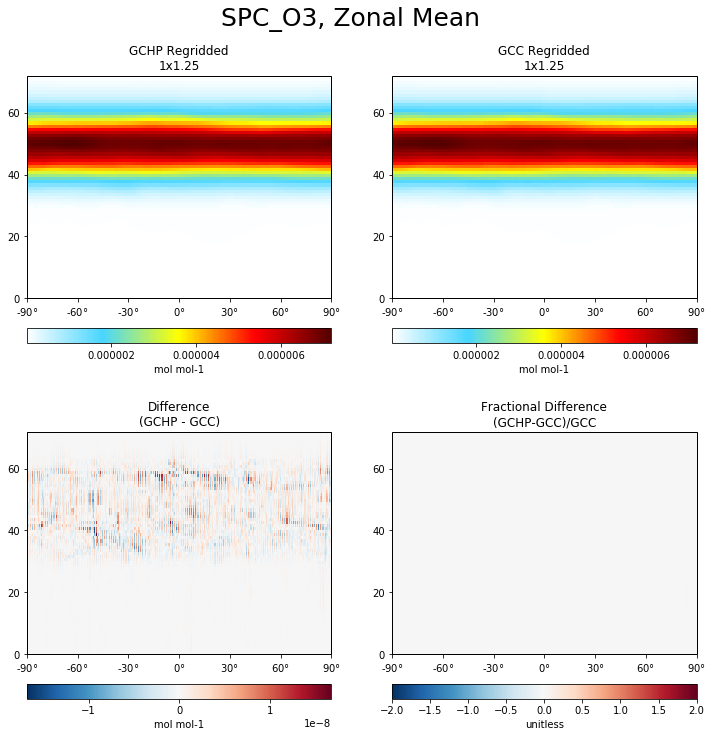

In [148]:
compare_zonal_mean(ds_gcc, ds_gchp, varlist=['SPC_O3'], weightsdir=weightsdir, flip_vert=True )

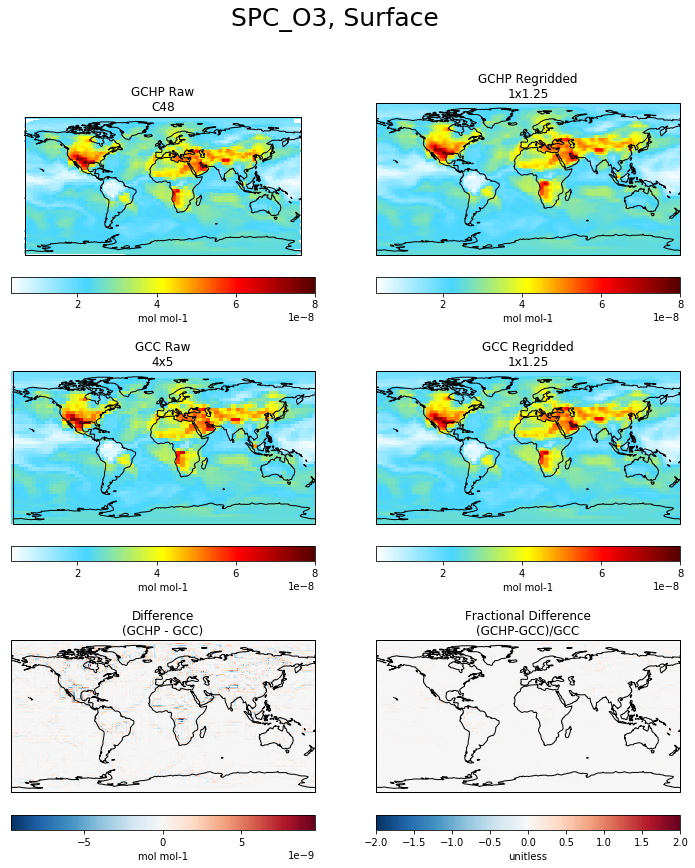

In [149]:
compare_single_level(ds_gcc, ds_gchp, varlist=['SPC_O3'], ilev=0, weightsdir=weightsdir, flip_vert=True )


## Store Grid Areas for Normalizing by Area

In [156]:
gcc_collection = 'StateMet_avg'
gcc_day = '20160701' # YYYYMMDD start date of time-averaging period
gcc_time='0000'      # HHmm: GCC filename shows start time of time-averaging period

gchp_collection = 'StateMet_avg'
gchp_day = '20160716' # YYYYMMDD
gchp_time='1200'      # HHmm: GCHP filename shows mid-point time of time-averaging period

gcc_met = get_gcc_filepath(gccdatadir, gcc_collection, gcc_day, gcc_time)
gchp_met = get_gchp_filepath(gchpdatadir, gchp_collection, gchp_day, gchp_time)
check_paths(gcc_met, gchp_met)

GCC path exists: /n/home08/elundgren/GC/testruns/12.0.0/geosfp_4x5_benchmark_1mo/GEOSChem.StateMet_avg.20160701_0000z.nc4
GCHP path exists: /n/home08/elundgren/GC/testruns/12.0.0/gchp_benchmark/OutputDir/GCHP.StateMet_avg.20160716_1200z.nc4


In [157]:
ds_gcc_met = xr.open_dataset(gcc_met)
ds_gchp_met = xr.open_dataset(gchp_met)
gcc_area = ds_gcc_a[varname].isel(lev=0,time=0)
gchp_area = ds_gchp_a['Met_AREAM2'].isel(lev=0,time=0)
print('GCC native grid area array shape: {}'.format(gcc_area.shape))
print('GCHP native grid area array shape: {}'.format(gchp_area.shape))

GCC native grid area array shape: (46, 72)
GCHP native grid area array shape: (288, 48)


## Compare diagnostic collections

### SpeciesConc

In [220]:
gcc_collection = 'SpeciesConc_avg'
gcc_day = '20160701' # YYYYMMDD start date of time-averaging period
gcc_time='0000'      # HHmm: GCC filename shows start time of time-averaging period

gchp_collection = 'SpeciesConc_avg'
gchp_day = '20160716' # YYYYMMDD
gchp_time='1200'      # HHmm: GCHP filename shows mid-point time of time-averaging period

gcc_spc = get_gcc_filepath(gccdatadir, gcc_collection, gcc_day, gcc_time)
gchp_spc = get_gchp_filepath(gchpdatadir, gchp_collection, gchp_day, gchp_time)
check_paths(gcc_spc, gchp_spc)

GCC path exists: /n/home08/elundgren/GC/testruns/12.0.0/geosfp_4x5_benchmark_1mo/GEOSChem.SpeciesConc_avg.20160701_0000z.nc4
GCHP path exists: /n/home08/elundgren/GC/testruns/12.0.0/gchp_benchmark/OutputDir/GCHP.SpeciesConc_avg.20160716_1200z.nc4


In [221]:
ds_gcc = xr.open_dataset(gcc_spc)
ds_gcc

<xarray.Dataset>
Dimensions:               (ilev: 73, lat: 46, lev: 72, lon: 72, time: 1)
Coordinates:
  * time                  (time) datetime64[ns] 2016-07-16T12:00:00
  * lev                   (lev) float64 0.9925 0.9775 0.9625 0.9475 0.9325 ...
  * ilev                  (ilev) float64 1.0 0.985 0.97 0.955 0.94 0.925 ...
  * lat                   (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 ...
  * lon                   (lon) float64 -180.0 -175.0 -170.0 -165.0 -160.0 ...
Data variables:
    hyam                  (lev) float64 0.02402 3.321 9.864 16.37 22.85 ...
    hybm                  (lev) float64 0.9925 0.9742 0.9526 0.9311 0.9096 ...
    hyai                  (ilev) float64 0.0 0.04805 6.594 13.13 19.61 26.09 ...
    hybi                  (ilev) float64 1.0 0.985 0.9634 0.9419 0.9204 ...
    P0                    float64 1e+03
    AREA                  (lat, lon) float32 2.16047e+09 2.16047e+09 ...
    SpeciesConc_pFe       (time, lev, lat, lon) float64 5.533e-16 5.533e-

In [222]:
ds_gchp = xr.open_dataset(gchp_spc)
ds_gchp

<xarray.Dataset>
Dimensions:               (lat: 288, lev: 72, lon: 48, time: 1)
Coordinates:
  * lon                   (lon) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * lat                   (lat) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * lev                   (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * time                  (time) datetime64[ns] 2016-07-16T12:00:00
Data variables:
    SpeciesConc_ACET      (time, lev, lat, lon) float64 2.666e-09 2.667e-09 ...
    SpeciesConc_ACTA      (time, lev, lat, lon) float64 7.79e-12 8.194e-12 ...
    SpeciesConc_AERI      (time, lev, lat, lon) float64 9.245e-14 1.014e-13 ...
    SpeciesConc_ALD2      (time, lev, lat, lon) float64 4.91e-10 4.865e-10 ...
    SpeciesConc_ALK4      (time, lev, lat, lon) float64 2.145e-10 1.994e-10 ...
    SpeciesConc_ASOA1     (time, lev, lat, lon) float64 2.364e-14 2.01e-14 ...
    SpeciesConc_ASOA2     (time, lev, lat, lon) float64 4.559e-15 3.519e-15 ...
    SpeciesConc_ASOA3    

In [223]:
[commonvars, commonvars2D, commonvars3D] = compare_varnames(ds_gcc, ds_gchp)

183 common variables (0 are 2-dim and 183 are 3-dim)
6 variables in gcc only (skip)
   Variable names: ['hyam', 'hybm', 'hyai', 'hybi', 'P0', 'AREA']
Common variables: ['SpeciesConc_ACET', 'SpeciesConc_ACTA', 'SpeciesConc_AERI', 'SpeciesConc_ALD2', 'SpeciesConc_ALK4', 'SpeciesConc_ASOA1', 'SpeciesConc_ASOA2', 'SpeciesConc_ASOA3', 'SpeciesConc_ASOAN', 'SpeciesConc_ASOG1', 'SpeciesConc_ASOG2', 'SpeciesConc_ASOG3', 'SpeciesConc_BCPI', 'SpeciesConc_BCPO', 'SpeciesConc_BENZ', 'SpeciesConc_Br', 'SpeciesConc_Br2', 'SpeciesConc_BrCl', 'SpeciesConc_BrNO2', 'SpeciesConc_BrNO3', 'SpeciesConc_BrO', 'SpeciesConc_BrSALA', 'SpeciesConc_BrSALC', 'SpeciesConc_C2H6', 'SpeciesConc_C3H8', 'SpeciesConc_CCl4', 'SpeciesConc_CFC11', 'SpeciesConc_CFC113', 'SpeciesConc_CFC114', 'SpeciesConc_CFC115', 'SpeciesConc_CFC12', 'SpeciesConc_CH2Br2', 'SpeciesConc_CH2Cl2', 'SpeciesConc_CH2I2', 'SpeciesConc_CH2IBr', 'SpeciesConc_CH2ICl', 'SpeciesConc_CH2O', 'SpeciesConc_CH3Br', 'SpeciesConc_CH3CCl3', 'SpeciesConc_CH3Cl', 

### Look at one variable more closely

In [224]:
varname='SpeciesConc_Br2'
get_stats(ds_gcc, ds_gchp, varname)

Variable array type: <class 'xarray.core.dataarray.DataArray'>
Variable values array type: <class 'numpy.ndarray'>
Array shapes:
    GCC:  (1, 72, 46, 72)
    GCHP: (1, 72, 288, 48)
Global Mean:
    GCC:  1.2115295e-13
    GCHP: 9.748267e-14
Global Min:
    GCC:  0.0
    GCHP: 0.0
Global Max:
    GCC:  3.15201294e-12
    GCHP: 3.2240341e-12


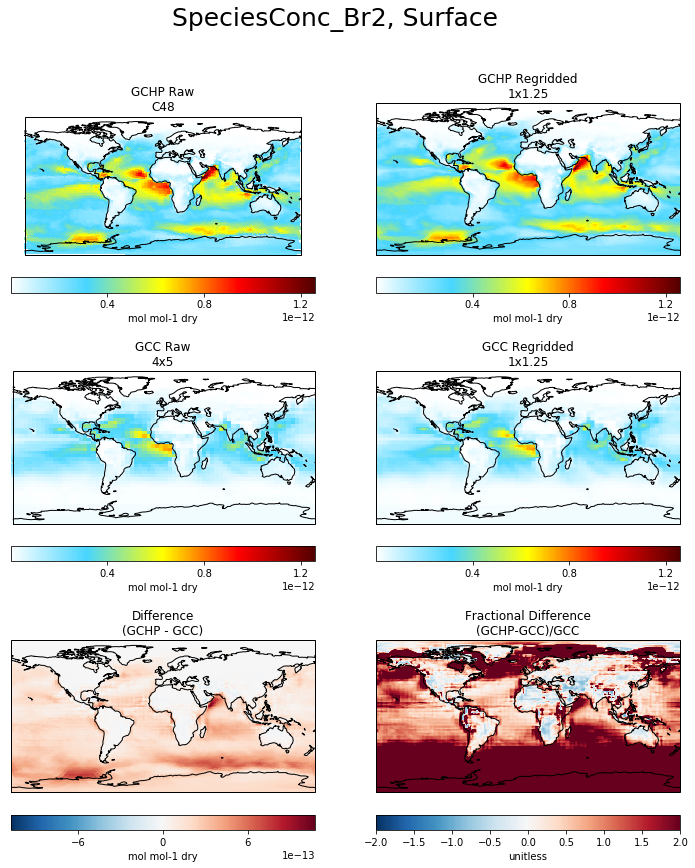

In [225]:
compare_single_level(ds_gcc, ds_gchp, varlist=[varname], weightsdir=weightsdir)

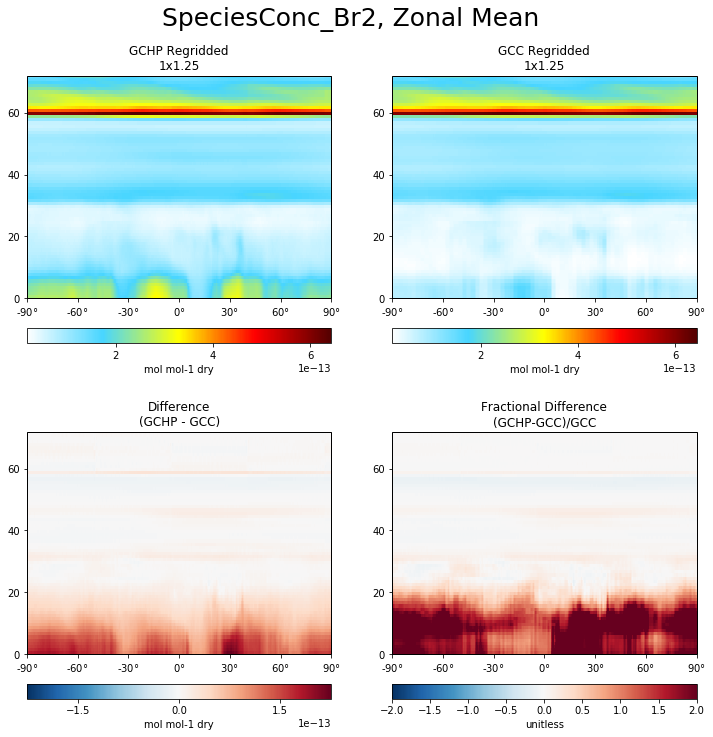

In [184]:
compare_zonal_mean(ds_gcc, ds_gchp, varlist=[varname], weightsdir=weightsdir )

In [195]:
# Save single plot to pdf
pdfname = os.path.join(plotsdir,'{}_Zonal_Mean.pdf'.format(varname))
compare_zonal_mean(ds_gcc, ds_gchp, varlist=[varname], weightsdir=weightsdir,
                   savepdf=True, pdfname=pdfname )


Creating /n/home08/elundgren/GC/testruns/12.0.0/plots/SpeciesConc_Br2_Zonal_Mean.pdf for 1 species
0 

### Save several plots to file

In [203]:
# use commonvars, commonvars2D, or commonvars2D to include all variables
varlist = ['SpeciesConc_O3', 'SpeciesConc_HNO3', 'SpeciesConc_DST1']

In [204]:
# Save surface comparison for all species
pdfname = os.path.join(plotsdir,'{}_Surface.pdf'.format(gchp_collection))
compare_single_level(ds_gcc, ds_gchp, varlist=varlist, ilev=0, weightsdir=weightsdir, 
                     savepdf=True, pdfname=pdfname )


Creating /n/home08/elundgren/GC/testruns/12.0.0/plots/SpeciesConc_avg_Surface.pdf for 3 variables
0 1 2 

In [207]:
# Save 500 hPa comparison for all species
ilev=22
pdfname = os.path.join(plotsdir,'{}_L{}.pdf'.format(gchp_collection, ilev))
compare_single_level(ds_gcc, ds_gchp, varlist=varlist, ilev=ilev, weightsdir=weightsdir, 
                    savepdf=True, pdfname=pdfname )


Creating /n/home08/elundgren/GC/testruns/12.0.0/plots/SpeciesConc_avg_L22.pdf for 3 variables
0 1 2 

In [206]:
# Save zonal mean comparison for all species
pdfname = os.path.join(plotsdir,'{}_ZonalMean.pdf'.format(gchp_collection))
compare_zonal_mean(ds_gcc, ds_gchp, varlist=varlist, weightsdir=weightsdir, 
                   savepdf=True, pdfname=pdfname )


Creating /n/home08/elundgren/GC/testruns/12.0.0/plots/SpeciesConc_avg_ZonalMean.pdf for 3 variables
0 1 2 

### Emissions

In [227]:
gcc_collection = 'Emissions'
gcc_day = '20160701' # YYYYMMDD start date of time-averaging period
gcc_time='0000'      # HHmm: GCC filename shows start time of time-averaging period

gchp_collection = gcc_collection
gchp_day = '20160716' # YYYYMMDD
gchp_time='1200'      # HHmm: GCHP filename shows mid-point time of time-averaging period

gcc_emis = get_gcc_filepath(gccdatadir, gcc_collection, gcc_day, gcc_time)
gchp_emis = get_gchp_filepath(gchpdatadir, gchp_collection, gchp_day, gchp_time)
check_paths(gcc_emis, gchp_emis)

GCC path exists: /n/home08/elundgren/GC/testruns/12.0.0/geosfp_4x5_benchmark_1mo/HEMCO_diagnostics.201607010000.nc
GCHP path exists: /n/home08/elundgren/GC/testruns/12.0.0/gchp_benchmark/OutputDir/GCHP.Emissions.20160716_1200z.nc4


In [228]:
ds_gcc = xr.open_dataset(gcc_emis)
ds_gchp = xr.open_dataset(gchp_emis)
[commonvars, commonvars2D, commonvars3D] = compare_varnames(ds_gcc, ds_gchp)

127 common variables (77 are 2-dim and 50 are 3-dim)
4 variables in gcc only (skip)
   Variable names: ['hyam', 'hybm', 'P0', 'AREA']


In [229]:
commonvars2D

['EmisACET_BioBurn',
 'EmisACET_Biofuel',
 'EmisACET_Biogenic',
 'EmisACET_DirectBio',
 'EmisACET_MethylBut',
 'EmisACET_Monoterp',
 'EmisACET_Ocean',
 'EmisALD2_BioBurn',
 'EmisALD2_Biofuel',
 'EmisALD2_Biogenic',
 'EmisALD2_Ocean',
 'EmisALD2_Senesc',
 'EmisALK4_BioBurn',
 'EmisALK4_Biofuel',
 'EmisBCPI_BioBurn',
 'EmisBCPI_Biofuel',
 'EmisBCPO_BioBurn',
 'EmisBCPO_Biofuel',
 'EmisBENZ_BioBurn',
 'EmisBENZ_Biofuel',
 'EmisBr2_Ocean',
 'EmisC2H6_BioBurn',
 'EmisC2H6_Biofuel',
 'EmisC3H8_BioBurn',
 'EmisC3H8_Biofuel',
 'EmisCH2Br2_Ocean',
 'EmisCH2O_BioBurn',
 'EmisCH2O_Biofuel',
 'EmisCHBr3_Ocean',
 'EmisCO_BioBurn',
 'EmisCO_Biofuel',
 'EmisCO_Monoterp',
 'EmisCO_Ship',
 'EmisDMS_Ocean',
 'EmisDST1_Natural',
 'EmisDST2_Natural',
 'EmisDST3_Natural',
 'EmisDST4_Natural',
 'EmisEOH_BioBurn',
 'EmisEOH_Biofuel',
 'EmisEOH_Biogenic',
 'EmisEOH_Senesc',
 'EmisISOP_Biogenic',
 'EmisMACR_Biofuel',
 'EmisMEK_BioBurn',
 'EmisMEK_Biofuel',
 'EmisMGLY_BioBurn',
 'EmisNH3_BioBurn',
 'EmisNH3_Bio

In [230]:
get_stats( ds_gcc, ds_gchp, 'EmisTOLU_BioBurn')

Variable array type: <class 'xarray.core.dataarray.DataArray'>
Variable values array type: <class 'numpy.ndarray'>
Array shapes:
    GCC:  (1, 46, 72)
    GCHP: (1, 288, 48)
Global Mean:
    GCC:  416390652.0118146
    GCHP: 357929661.6746364
Global Min:
    GCC:  0.0
    GCHP: 0.0
Global Max:
    GCC:  217448988672.0
    GCHP: 207500296192.0


### WetLossLS (requires normalization by area)

In [232]:
gcc_collection = 'WetLossLS'
gcc_day = '20160701' # YYYYMMDD start date of time-averaging period
gcc_time='0000'      # HHmm: GCC filename shows start time of time-averaging period

gchp_collection = gcc_collection
gchp_day = '20160716' # YYYYMMDD
gchp_time='1200'      # HHmm: GCHP filename shows mid-point time of time-averaging period

gcc_wetls = get_gcc_filepath(gccdatadir, gcc_collection, gcc_day, gcc_time)
gchp_wetls = get_gchp_filepath(gchpdatadir, gchp_collection, gchp_day, gchp_time)
check_paths(gcc_wetls, gchp_wetls)

GCC path exists: /n/home08/elundgren/GC/testruns/12.0.0/geosfp_4x5_benchmark_1mo/GEOSChem.WetLossLS.20160701_0000z.nc4
GCHP path exists: /n/home08/elundgren/GC/testruns/12.0.0/gchp_benchmark/OutputDir/GCHP.WetLossLS.20160716_1200z.nc4


In [233]:
ds_gcc = xr.open_dataset(gcc_wetls)
ds_gchp = xr.open_dataset(gchp_wetls)
[commonvars, commonvars2D, commonvars3D] = compare_varnames(ds_gcc, ds_gchp)

107 common variables (0 are 2-dim and 107 are 3-dim)
6 variables in gcc only (skip)
   Variable names: ['hyam', 'hybm', 'hyai', 'hybi', 'P0', 'AREA']
